In [1]:
!pip install --upgrade scikit-learn --user

Requirement already up-to-date: scikit-learn in c:\users\xjiang24\appdata\roaming\python\python36\site-packages (0.24.2)


In [2]:
!pip install --user pandas numpy scipy matplotlib datetime scikit-learn mlxtend lightgbm --user

In [9]:
# import sys

# print(sys.version)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)]


In [12]:
# sys.executable

'C:\\Program Files\\ArcGIS\\Pro\\bin\\Python\\envs\\arcgispro-py3\\python.exe'

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [7]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 335
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 50
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [9]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars-final.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars-final.csv size is (1000000, 2242)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
vars-final.csv                                             variable  filter score
0                                        fraud_label      1.000000
2128                     max_count_by_fulladdress_30      0.356094
2108                         max_count_by_address_30      0.355872
2107                          max_count_by_address_7      0.343199
2127                      max_count_by_fulladdress_7      0.342275
10                                 address_day_since      0.331458
45                             fulladdress_day_since      0.330520
16                                  address_count_30      0.329960
51                              fulladdress_count_30      0.329125
2106                          max_count_by_address_3      0.328576
2126                      max_count_by_fulladdress_3      0.328381
15                 

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [10]:
filter_score.head(30)

,variable,filter score
0,fraud_label,1.000000
2128,max_count_by_fulladdress_30,0.356094
2108,max_count_by_address_30,0.355872
2107,max_count_by_address_7,0.343199
2127,max_count_by_fulladdress_7,0.342275
10,address_day_since,0.331458
45,fulladdress_day_since,0.330520
16,address_count_30,0.329960
51,fulladdress_count_30,0.329125
2106,max_count_by_address_3,0.328576


In [11]:
filter_score.tail(10)

,variable,filter score
2033,ssn_fulladdress_unique_count_for_name_1,0.000005
2067,ssn_fulladdress_unique_count_for_ssn_lastname_3,0.000004
2061,ssn_fulladdress_unique_count_for_ssn_firstname_1,0.000004
1771,ssn_zip5_unique_count_for_address_14,0.000003
1845,ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
1906,ssn_dob_unique_count_for_ssn_firstname_0,0.000003
1508,homephone_name_dob_unique_count_for_zip5_0,0.000003
1648,ssn_lastname_unique_count_for_name_0,0.000001
1171,name_fulladdress_unique_count_for_zip5_30,0.000001
1017,fulladdress_unique_count_for_address_0,-0.000000


In [12]:
filter_score.shape

(2242, 2)

In [13]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_address_3', 'max_count_by_fulladdress_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_homephone_name_dob_60', 'fulladdress_count_0_by_30', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_homephone_name_dob_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_name_dob_60', 'address_unique_c

In [14]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,max_count_by_fulladdress_30,max_count_by_address_30,max_count_by_address_7,max_count_by_fulladdress_7,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,max_count_by_address_3,max_count_by_fulladdress_3,...,max_count_by_ssn_name_dob_1,homephone_count_7,name_dob_count_7,ssn_dob_count_7,ssn_count_7,name_dob_count_0_by_14,fulladdress_homephone_count_0_by_14,ssn_firstname_count_7,ssn_lastname_count_7,zip5_day_since
record,,,,,,,,,,,,,,,,,,,,,
38511.0,14.0,14.0,10.0,10.0,0.0,0.0,12.0,12.0,6.0,6.0,...,1.0,1.0,1.0,1.0,1.0,14.0,14.0,1.0,1.0,0.0
38512.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,1.0,14.0,14.0,1.0,1.0,6.0
38513.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,3.0,1.0,1.0,1.0,14.0,14.0,1.0,1.0,4.0
38514.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,14.0,14.0,1.0,1.0,1.0
38515.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,14.0,14.0,1.0,1.0,10.0


In [15]:
df_keep.shape

(794997, 335)

In [16]:
Y.head()

,fraud_label
record,
38511.0,1.0
38512.0,0.0
38513.0,0.0
38514.0,0.0
38515.0,0.0


In [17]:
Y = Y.values
Y_save = Y.copy()

In [18]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [19]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:11:22.523687


In [20]:
print(X.shape,Y.shape)

(794997, 335) (794997, 1)


In [21]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [22]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [23]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

Wall time: 2h 31min 17s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          k_features=(50, 50), n_jobs=-1,
                          scoring=<function fdr at 0x000001E3EDC7DD90>)

In [24]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 2:43:09.854649


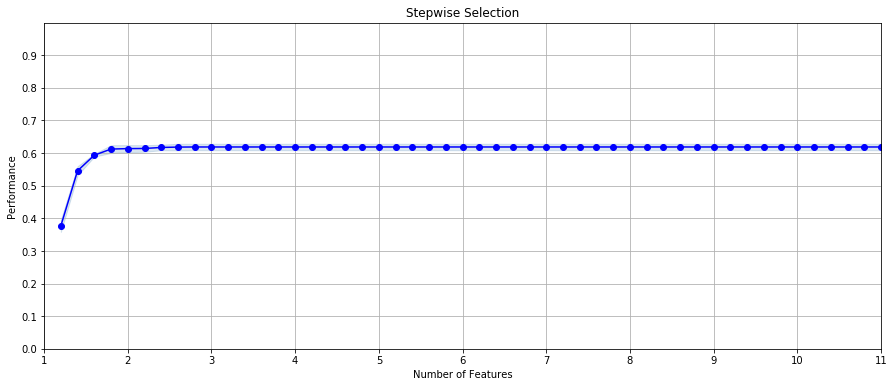

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [26]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [28]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.354400626795508, 0.399582136328023, 0.37607...",0.376687,"(max_count_by_address_30,)",0.0415193,0.0184503,0.0130463,1.0,max_count_by_address_30
2,"(1, 210)","[0.5267693914860276, 0.5510577174196918, 0.559...",0.545834,"(max_count_by_address_30, max_count_by_ssn_dob_7)",0.0313529,0.0139326,0.00985183,2.0,max_count_by_ssn_dob_7
3,"(1, 198, 210)","[0.5873596239226953, 0.5962392269522069, 0.597...",0.593541,"(max_count_by_address_30, max_count_by_homepho...",0.0098615,0.00438225,0.00309872,3.0,max_count_by_homephone_7
4,"(1, 198, 210, 249)","[0.5965003917471925, 0.6155654217811439, 0.625...",0.612431,"(max_count_by_address_30, max_count_by_homepho...",0.0268593,0.0119357,0.00843984,4.0,zip5_unique_count_for_fulladdress_dob_1
5,"(1, 198, 210, 249, 280)","[0.5991120396970488, 0.6168712457560721, 0.625...",0.613737,"(max_count_by_address_30, max_count_by_homepho...",0.0245058,0.0108899,0.0077003,5.0,name_day_since
6,"(0, 1, 198, 210, 249, 280)","[0.6001566988769914, 0.6189605641159571, 0.623...",0.614173,"(max_count_by_fulladdress_30, max_count_by_add...",0.0226722,0.0100751,0.00712416,6.0,max_count_by_fulladdress_30
7,"(0, 1, 191, 198, 210, 249, 280)","[0.6056411595716897, 0.6207887176808566, 0.625...",0.617307,"(max_count_by_fulladdress_30, max_count_by_add...",0.019058,0.00846897,0.00598847,7.0,max_count_by_ssn_firstname_30
8,"(0, 1, 191, 198, 209, 210, 249, 280)","[0.604074170801776, 0.623400365630713, 0.62784...",0.618438,"(max_count_by_fulladdress_30, max_count_by_add...",0.0232175,0.0103174,0.00729549,8.0,max_count_by_homephone_30
9,"(0, 1, 6, 191, 198, 209, 210, 249, 280)","[0.6051188299817185, 0.622616871245756, 0.6286...",0.618786,"(max_count_by_fulladdress_30, max_count_by_add...",0.0224374,0.00997074,0.00705037,9.0,address_count_30
10,"(0, 1, 2, 6, 191, 198, 209, 210, 249, 280)","[0.6051188299817185, 0.622616871245756, 0.6286...",0.618786,"(max_count_by_fulladdress_30, max_count_by_add...",0.0224374,0.00997074,0.00705037,10.0,max_count_by_address_7


In [29]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [30]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


1                               max_count_by_address_30
2                                max_count_by_ssn_dob_7
3                              max_count_by_homephone_7
4               zip5_unique_count_for_fulladdress_dob_1
5                                        name_day_since
6                           max_count_by_fulladdress_30
7                         max_count_by_ssn_firstname_30
8                             max_count_by_homephone_30
9                                      address_count_30
10                               max_count_by_address_7
11                                    address_day_since
12                               max_count_by_address_3
13                           max_count_by_fulladdress_3
14                                     address_count_14
15                                 fulladdress_count_14
16                               max_count_by_address_1
17                           max_count_by_fulladdress_1
18                                      address_

In [31]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.356094
max_count_by_address_30,0.355872
max_count_by_address_7,0.343199
max_count_by_fulladdress_7,0.342275
address_day_since,0.331458
...,...
ssn_dob_unique_count_for_ssn_firstname_0,0.000003
homephone_name_dob_unique_count_for_zip5_0,0.000003
ssn_lastname_unique_count_for_name_0,0.000001


In [32]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
max_count_by_ssn_dob_7
max_count_by_homephone_7
zip5_unique_count_for_fulladdress_dob_1
name_day_since


In [33]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [34]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,max_count_by_address_30,0.355872
1,2,max_count_by_ssn_dob_7,0.225774
2,3,max_count_by_homephone_7,0.232724
3,4,zip5_unique_count_for_fulladdress_dob_1,0.219167
4,5,name_day_since,0.209358
5,6,max_count_by_fulladdress_30,0.356094
6,7,max_count_by_ssn_firstname_30,0.236333
7,8,max_count_by_homephone_30,0.226131
8,9,address_count_30,0.329960
9,10,max_count_by_address_7,0.343199


In [35]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'max_count_by_homephone_7',
 'zip5_unique_count_for_fulladdress_dob_1',
 'name_day_since',
 'max_count_by_fulladdress_30',
 'max_count_by_ssn_firstname_30',
 'max_count_by_homephone_30',
 'address_count_30',
 'max_count_by_address_7',
 'address_day_since',
 'max_count_by_address_3',
 'max_count_by_fulladdress_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'fulladdress_count_7',
 'address_count_0_by_30',
 'fulladdress_unique_count_for_ssn_homephone_60',
 'fulladdress_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_homephone_name_dob_60',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_name_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_firstname_60',
 'fulladdress_unique_count_for_ssn_60',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_un

In [36]:
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.356094
max_count_by_address_30,0.355872
max_count_by_address_7,0.343199
max_count_by_fulladdress_7,0.342275
address_day_since,0.331458
...,...
ssn_dob_unique_count_for_ssn_firstname_0,0.000003
homephone_name_dob_unique_count_for_zip5_0,0.000003
ssn_lastname_unique_count_for_name_0,0.000001


In [37]:
%%time
df = pd.read_csv(file_name)
df.shape

Wall time: 5min 17s


(1000000, 2242)

In [38]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 52)


In [39]:
df_keep.to_csv('vars_final.csv',index=False)

In [40]:
print("duration: ", dt.datetime.now() - start_time)

duration:  2:50:38.049088
